# Experiment 1 Results

In [16]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd
from get_results import read_results, get_performance_profiles

In [17]:
FIG_DIRECTORY = "../fig"
SAVE_FIG = True

In [18]:
df = read_results("../results.csv")
df.head()

,name,timelimit,type,num,solver,lp_tangent,solvetime,obj_val,bound,iterations,LPcuts,IPcuts,gap,dev
0,cdp_GKD-b_17_n50_b02_m15_2_repoa_False,600.0,CDP,50,repoa,False,0.034859,12360.8,12360.8,5,0,6,0.000000e+00,0.000000e+00
1,cdp_GKD-b_13_n50_b03_m5_3_repoa_False,600.0,CDP,50,repoa,False,0.038936,32206.3,32206.3,4,0,5,2.259172e-16,1.129586e-16
2,cdp_GKD-b_43_n150_b03_m15_3_repoa_False,600.0,CDP,150,repoa,False,0.051778,278268.3,278268.3,4,0,5,0.000000e+00,3.556029e-15
3,cdp_GKD-b_18_n50_b03_m15_3_repoa_False,600.0,CDP,50,repoa,False,0.043288,40045.1,40045.1,4,0,5,-1.816941e-16,0.000000e+00
4,cdp_GKD-b_20_n50_b02_m15_2_repoa_False,600.0,CDP,50,repoa,False,0.053668,22757.9,22757.9,4,0,5,0.000000e+00,3.197113e-16


## Style Guides

In [19]:
# Full names
full_names = {
    "repoa": "Repeated ILP",
    "fcard": "Forced Cardinality",
    "concave_oa": "Concave OA",
    "glover": "Glover Linearisation",
    "quad": "Quadratic CPLEX",
    "False": "No LP-tangents",
    "rootonly": "Root only LP-tangents",
    "True": "All LP-tangents",
}

# Color map
CM = dict(
    zip(
        full_names.keys(),
        [mpl.colormaps["Set1"](i) for i in range(len(full_names))],
    )
)
# Line styles & marker based on `lp_tangent`
LS = {"False": "-", "rootonly": "--", "True": ":"}
MS = {"False": "", "rootonly": "", "True": ""}


def get_legend_lines_names(df):
    lines = []
    names = []

    for solver in df["solver"].unique():
        lines.append(Line2D([0], [0], color=CM[solver], linewidth=2))
        names.append(full_names[solver])

    lines.append(Line2D([0], [0], color="none", linewidth=2))
    names.append("")

    for lp in df["lp_tangent"].unique():
        lines.append(
            Line2D([0], [0], color="grey", linewidth=2, linestyle=LS[lp], marker=MS[lp])
        )
        names.append(full_names[lp])

    return lines, names


def plot_pp(pp, ax, num_test=None):
    for s, lpt in pp.keys():
        times, steps = pp[s, lpt]
        ax.step(
            times,
            steps,
            label=(s, lpt),
            where="post",
            color=CM[s],
            ls=LS[lpt],
            marker=MS[lpt],
        )
    if num_test:
        ax.hlines(
            num_test, 0, df["timelimit"].max(), colors=["grey"], linestyles="dashed"
        )
    ax.set_ylim(bottom=0)


def get_group_by_table(df, column, operator):
    # Table with average solve time for varying 'n' values
    result = (
        df.groupby(["type", "num", "solver", "lp_tangent"])[column]
        .apply(operator)
        .reset_index()
    )
    result_pivot = result.pivot_table(
        index=["type", "num"], columns=["solver", "lp_tangent"], values=column
    ).reset_index()
    result_pivot = result_pivot[
        [
            ("type", ""),
            ("num", ""),
            ("repoa", "True"),
            ("repoa", "rootonly"),
            ("repoa", "False"),
            ("fcard", "True"),
            ("fcard", "rootonly"),
            ("fcard", "False"),
            ("glover", "False"),
            ("quad", "False"),
            ("concave_oa", "False"),
        ]
    ]
    old_col_names = list(result_pivot.columns)
    new_col_names = []
    for solver, lp in old_col_names:
        l1, l2 = solver, lp
        if solver in full_names:
            l1 = full_names[solver]
        else:
            l1 = solver.capitalize()
        if lp in full_names:
            l2 = full_names[lp]
        else:
            l2 = lp.capitalize()
        new_col_names.append((l1, l2))

    def tryindex(lst, x):
        try:
            return lst.index(x)
        except:
            return 0

    sorted(new_col_names, key=lambda x: tryindex(list(full_names.keys()), x[0]))
    sorted(new_col_names, key=lambda x: tryindex(list(full_names.keys()), x[1]))
    result_pivot.columns = pd.MultiIndex.from_tuples(new_col_names)

    return result_pivot

# Results Table

In [20]:
max_deviation_table = get_group_by_table(df, "dev", np.max)
display(max_deviation_table)

Type   Num    Repeated ILP                                       \
               All LP-tangents Root only LP-tangents No LP-tangents   
0    CDP    50    1.043205e-15          1.043205e-15   1.043205e-15   
1    CDP   150    4.189586e-15          4.189586e-15   4.189586e-15   
2    CDP   500    3.700854e-05          3.700854e-05   3.985650e-05   
3    GDP    50    3.880623e-14          3.880623e-14   3.880623e-14   
4    GDP   150    1.509511e-14          1.509511e-14   1.509511e-14   
5    GDP   500    6.754819e-05          6.754819e-05   4.045204e-05   
6   RCDP  1000    9.281137e-05          9.281137e-05   5.188770e-05   
7   RCDP  1500    7.035805e-05          7.035805e-05   7.342129e-05   
8   RCDP  2000    8.626082e-05          8.626082e-05   8.449245e-05   
9   RCDP  2500    6.812195e-05          6.812195e-05   9.064948e-05   
10  RCDP  3000    6.249383e-05          6.249383e-05   7.964498e-05   
11  RGDP  1000    5.819142e-15          5.819142e-15   5.819142e-15   
12  RGDP  1500    8.215200e-15          8.215200e-15   8.215200e-15   
13  RGDP  2000    7.815671e-15          7.815671e-15   7.815671e-15   
14  RGDP  2500    9.600653e-15          9.600653e-15   9.600653e-15   
15  RGDP  3000    1.362839e-14          1.362839e-14   1.362839e-14   

   Forced Cardinality                                       \
      All LP-tangents Root only LP-tangents No LP-tangents   
0        1.043205e-15          1.043205e-15   1.043205e-15   
1        4.189586e-15          4.189586e-15   4.189586e-15   
2        5.063509e-05          5.063509e-05   2.443355e-05   
3        3.880623e-14          3.880623e-14   3.880623e-14   
4        7.653867e-05          7.653867e-05   8.941651e-14   
5        6.865440e-05          6.865440e-05   4.390222e-05   
6        8.917151e-05          7.314263e-05   1.188628e-04   
7        6.743131e-05          1.419850e-04   1.353026e-04   
8        1.186295e-04          1.501118e-04   1.271298e-04   
9        1.261472e-04          1.440859e-04   1.261472e-04   
10       1.248015e-04          1.348816e-04   1.140726e-04   
11       6.375339e-15          6.375339e-15   6.375339e-15   
12       6.839547e-15          6.839547e-15   6.839547e-15   
13       9.508796e-15          9.508796e-15   9.508796e-15   
14       8.082762e-15          8.082762e-15   8.082762e-15   
15       1.540601e-14          1.540601e-14   1.540601e-14   

   Glover Linearisation Quadratic CPLEX     Concave OA  
         No LP-tangents  No LP-tangents No LP-tangents  
0          1.043205e-15    5.029533e-16            0.0  
1          9.662834e-15    1.361051e-02            0.0  
2          1.111263e-03             inf            0.0  
3          3.859533e-14    2.104484e-14            0.0  
4          1.551441e-14    9.442813e-04            0.0  
5          1.336973e-05    2.802394e-03            0.0  
6                   NaN             NaN            0.0  
7                   NaN             NaN            0.0  
8                   NaN             NaN            0.0  
9                   NaN             NaN            0.0  
10                  NaN             NaN            0.0  
11                  NaN             NaN            0.0  
12                  NaN             NaN            0.0  
13                  NaN             NaN            0.0  
14                  NaN             NaN            0.0  
15                  NaN             NaN            0.0

In [21]:
# Table with average solve time for varying 'n' values
average_solve_time_table = get_group_by_table(df, "solvetime", np.mean)
display(average_solve_time_table)

Type   Num    Repeated ILP                                       \
               All LP-tangents Root only LP-tangents No LP-tangents   
0    CDP    50        0.071045              0.066558       0.044479   
1    CDP   150        0.086263              0.080032       0.051865   
2    CDP   500        0.096180              0.097656       0.082061   
3    GDP    50        0.060967              0.057498       0.037927   
4    GDP   150        0.160914              0.154749       0.116578   
5    GDP   500        0.163715              0.164669       0.149904   
6   RCDP  1000        0.133322              0.122718       0.089919   
7   RCDP  1500        0.174838              0.167827       0.102777   
8   RCDP  2000        0.228598              0.224645       0.124162   
9   RCDP  2500        0.292801              0.287669       0.147540   
10  RCDP  3000        0.337228              0.335791       0.172662   
11  RGDP  1000        0.192337              0.190698       0.064828   
12  RGDP  1500        0.276994              0.273260       0.092074   
13  RGDP  2000        0.372871              0.365120       0.123123   
14  RGDP  2500        0.473546              0.469805       0.165506   
15  RGDP  3000        0.575808              0.575855       0.201477   

   Forced Cardinality                                       \
      All LP-tangents Root only LP-tangents No LP-tangents   
0            0.066512              0.063744       0.029788   
1            0.076523              0.076173       0.045991   
2            0.442178              0.431797       0.664402   
3            0.054244              0.051984       0.026790   
4            0.079650              0.076793       0.043978   
5            0.637183              0.638086       0.775379   
6            0.722615              0.654010       0.604147   
7            1.342093              1.114985       1.111519   
8            2.411476              2.150856       1.880764   
9            3.558038              3.354839       3.657092   
10           4.376424              3.711523       5.062125   
11           0.232299              0.222377       0.103139   
12           0.344041              0.328495       0.159690   
13           0.455720              0.432894       0.219332   
14           0.580481              0.551581       0.286727   
15           0.693988              0.667790       0.585513   

   Glover Linearisation Quadratic CPLEX     Concave OA  
         No LP-tangents  No LP-tangents No LP-tangents  
0              0.435318      152.804982     600.007233  
1             58.214711      600.001116     600.007725  
2            534.589949      600.418041     600.007176  
3              0.079720        0.642203     300.042306  
4              1.734833       74.606768     300.013818  
5             82.933726      270.485325     300.025931  
6                   NaN             NaN     600.194365  
7                   NaN             NaN     600.210337  
8                   NaN             NaN     600.032081  
9                   NaN             NaN     600.222102  
10                  NaN             NaN     600.070902  
11                  NaN             NaN       0.273657  
12                  NaN             NaN       0.397523  
13                  NaN             NaN       0.559233  
14                  NaN             NaN       0.752698  
15                  NaN             NaN       0.739162

In [22]:
latex = average_solve_time_table.style
latex = latex.format(precision=4)
latex = latex.hide(axis="index")
latex_str = latex.to_latex(multicol_align="c")
print(latex_str)

\begin{tabular}{lrrrrrrrrrr}
Type & Num & \multicolumn{3}{c}{Repeated ILP} & \multicolumn{3}{c}{Forced Cardinality} & Glover Linearisation & Quadratic CPLEX & Concave OA \\
 &  & All LP-tangents & Root only LP-tangents & No LP-tangents & All LP-tangents & Root only LP-tangents & No LP-tangents & No LP-tangents & No LP-tangents & No LP-tangents \\
CDP & 50 & 0.0710 & 0.0666 & 0.0445 & 0.0665 & 0.0637 & 0.0298 & 0.4353 & 152.8050 & 600.0072 \\
CDP & 150 & 0.0863 & 0.0800 & 0.0519 & 0.0765 & 0.0762 & 0.0460 & 58.2147 & 600.0011 & 600.0077 \\
CDP & 500 & 0.0962 & 0.0977 & 0.0821 & 0.4422 & 0.4318 & 0.6644 & 534.5899 & 600.4180 & 600.0072 \\
GDP & 50 & 0.0610 & 0.0575 & 0.0379 & 0.0542 & 0.0520 & 0.0268 & 0.0797 & 0.6422 & 300.0423 \\
GDP & 150 & 0.1609 & 0.1547 & 0.1166 & 0.0797 & 0.0768 & 0.0440 & 1.7348 & 74.6068 & 300.0138 \\
GDP & 500 & 0.1637 & 0.1647 & 0.1499 & 0.6372 & 0.6381 & 0.7754 & 82.9337 & 270.4853 & 300.0259 \\
RCDP & 1000 & 0.1333 & 0.1227 & 0.0899 & 0.7226 & 0.6540 & 0.604

Take this, and add in

```latex
\begin{tabular}{@{\extracolsep{4pt}}l........r@{}}
```

and

```latex
\cline{}
\thead{}
\toprule
\midrule
\bottomrule
```

# CDP

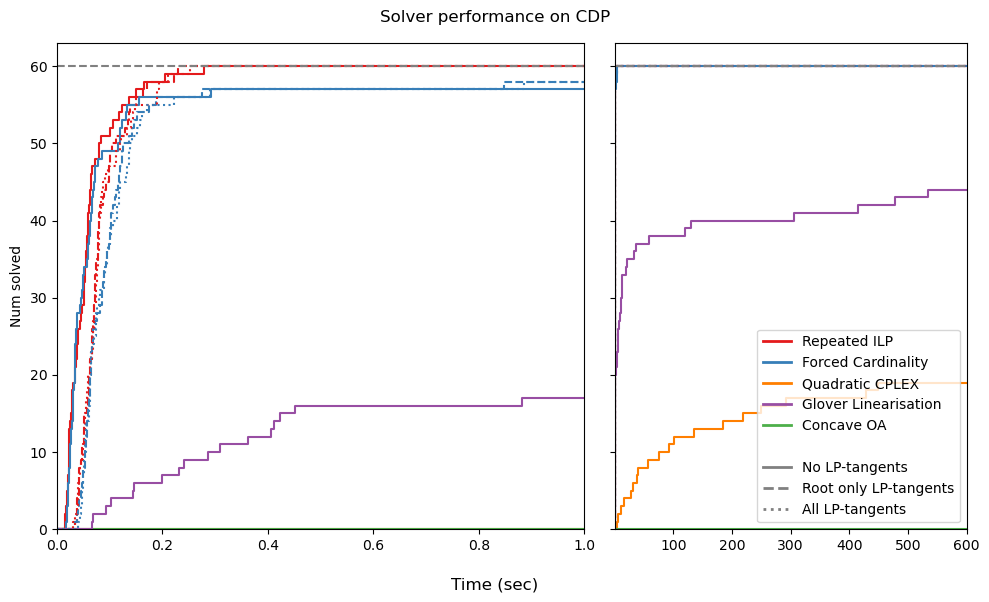

Max CDP solve time for forced cardinality: 4.382771253585815 seconds


In [23]:
_df = df[df["type"] == "CDP"]
num_test = 60
pp = get_performance_profiles(_df)
middle_time = 1

fig, axes = plt.subplots(1, 2, sharey=True, width_ratios=[3, 2], figsize=(10, 6))
for ax in axes:
    plot_pp(pp, ax, num_test)

axes[0].set_xlim(0, middle_time)
axes[1].set_xlim(middle_time, 600)

lines, names = get_legend_lines_names(_df)
axes[1].legend(lines, names, loc="lower right")

fig.supxlabel("Time (sec)")
axes[0].set_ylabel("Num solved")
fig.suptitle("Solver performance on CDP")
fig.tight_layout()
if SAVE_FIG:
    plt.savefig(f"{FIG_DIRECTORY}/pp_cdp.pdf")
plt.show()

print(
    f"Max CDP solve time for forced cardinality: {df[(df['type']=='CDP')&(df['solver'] == 'fcard')]['solvetime'].max()} seconds"
)

# GDP

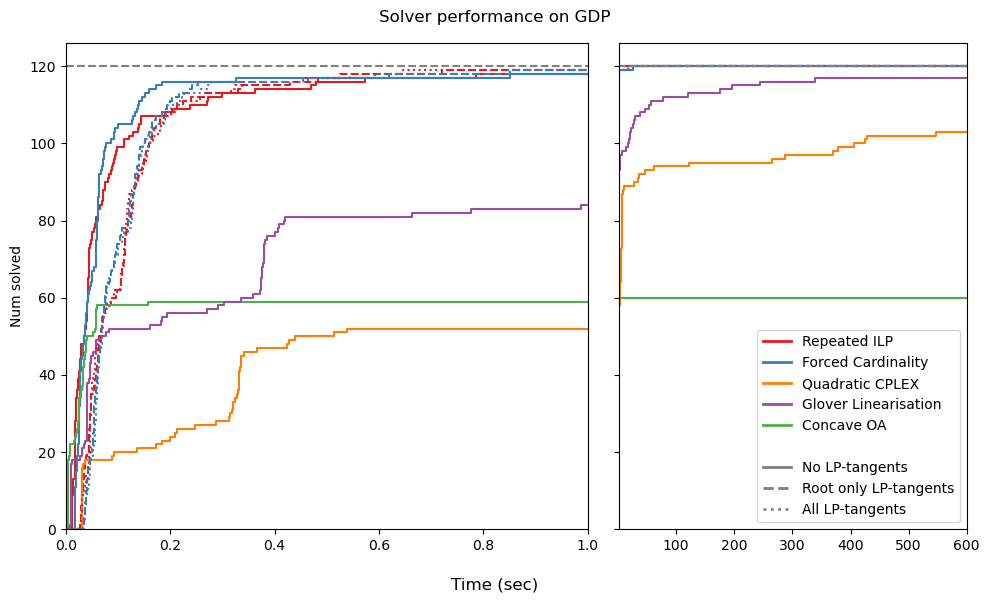

Max GDP solve time for forced cardinality: 25.49518656730652 seconds


In [24]:
_df = df[df["type"] == "GDP"]
num_test = 120
pp = get_performance_profiles(_df)
middle_time = 1

fig, axes = plt.subplots(1, 2, sharey=True, width_ratios=[3, 2], figsize=(10, 6))
for ax in axes:
    plot_pp(pp, ax, num_test)

axes[0].set_xlim(0, middle_time)
axes[1].set_xlim(middle_time, 600)

lines, names = get_legend_lines_names(_df)
axes[1].legend(lines, names, loc="lower right")

fig.supxlabel("Time (sec)")
axes[0].set_ylabel("Num solved")
fig.suptitle("Solver performance on GDP")
fig.tight_layout()
if SAVE_FIG:
    plt.savefig(f"{FIG_DIRECTORY}/pp_gdp.pdf")
plt.show()

print(
    f"Max GDP solve time for forced cardinality: {df[(df['type']=='GDP')&(df['solver'] == 'fcard')]['solvetime'].max()} seconds"
)

# Cuts Used

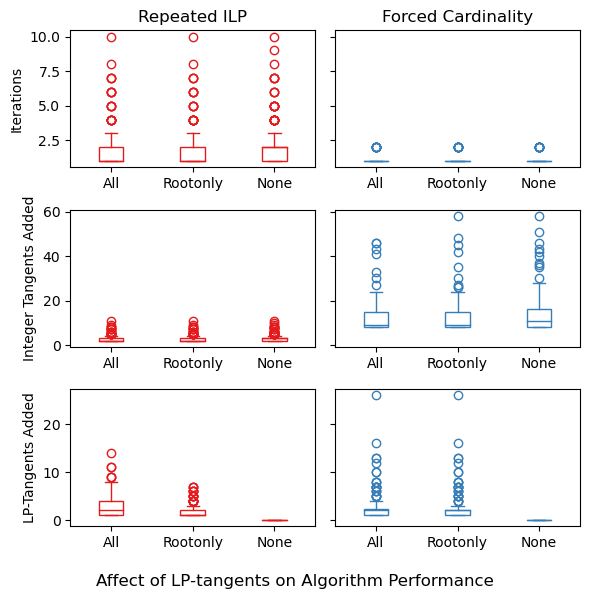

In [25]:
_df = df[(df["type"] == "CDP") | (df["type"] == "GDP")]

solvers = ["repoa", "fcard"]
lp_tangent = ["True", "rootonly", "False"]
metrics = ["iterations", "IPcuts", "LPcuts"]
fig, axes = plt.subplots(len(metrics), 2, sharey="row", figsize=(6, 6))

for r in range(len(metrics)):
    for c in range(len(solvers)):
        bp = [
            _df[(_df["solver"] == solvers[c]) & (_df["lp_tangent"] == lpt)][metrics[r]]
            for lpt in lp_tangent
        ]
        col = CM[solvers[c]]
        axes[r, c].boxplot(
            bp,
            labels=["All", "Rootonly", "None"],
            patch_artist=True,
            boxprops=dict(facecolor="None", color=col),
            capprops=dict(color=col),
            whiskerprops=dict(color=col),
            flierprops=dict(color=col, markeredgecolor=col),
            medianprops=dict(color=col),
        )

axes[0, 0].set_ylabel("Iterations")
axes[1, 0].set_ylabel("Integer Tangents Added")
axes[2, 0].set_ylabel("LP-Tangents Added")
axes[0, 0].set_title("Repeated ILP")
axes[0, 1].set_title("Forced Cardinality")

fig.supxlabel("Affect of LP-tangents on Algorithm Performance")
fig.tight_layout()
if SAVE_FIG:
    plt.savefig(f"{FIG_DIRECTORY}/lp_tan_impact.pdf")
plt.show()

# Random CDP

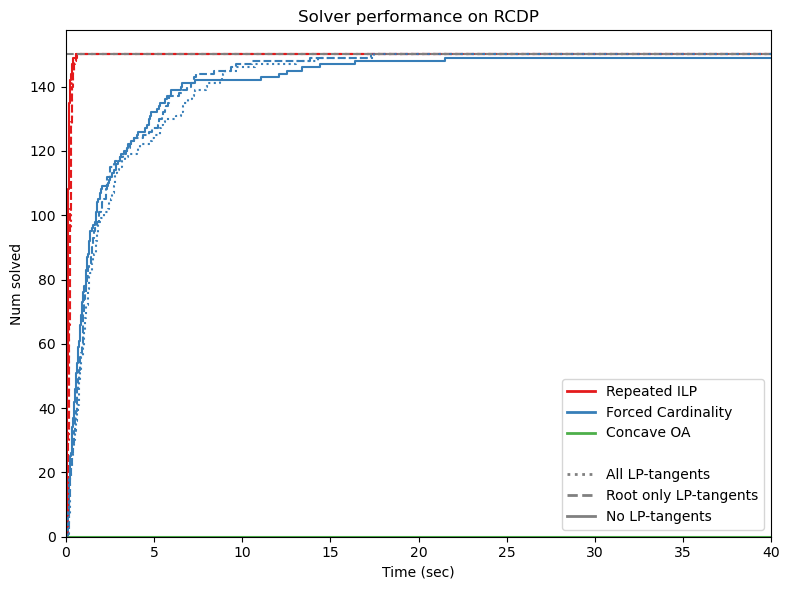

In [26]:
df_rcdp = df[df["type"] == "RCDP"]
num_test_rcdp = 150
timewindow_rcdp = 40

pp = get_performance_profiles(df_rcdp)


fig, axes = plt.subplots(1, figsize=(8, 6))
plot_pp(pp, axes, num_test_rcdp)

axes.set_xlim(0, timewindow_rcdp)

lines, names = get_legend_lines_names(df_rcdp)
axes.legend(lines, names, loc="lower right")

axes.set_xlabel("Time (sec)")
axes.set_ylabel("Num solved")
axes.set_title("Solver performance on RCDP")
fig.tight_layout()
if SAVE_FIG:
    plt.savefig(f"{FIG_DIRECTORY}/pp_rcdp.pdf")
plt.show()

# Random GDP

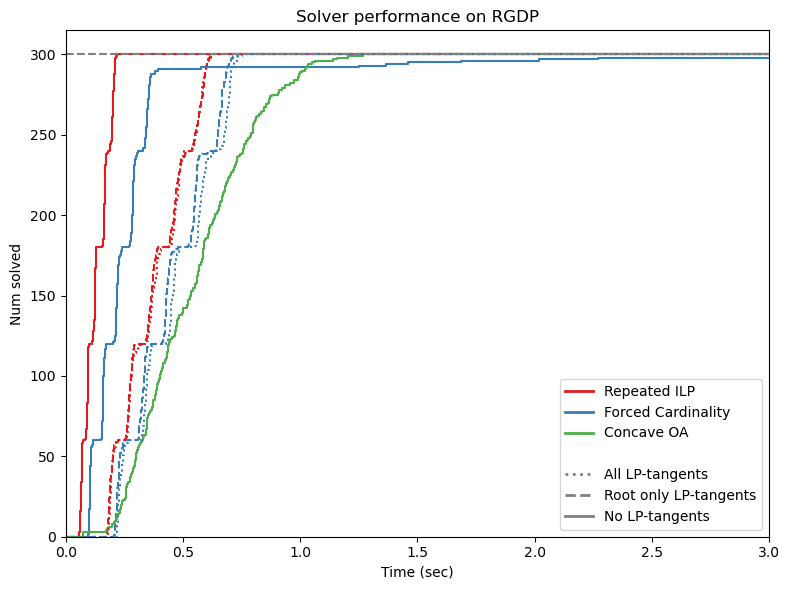

In [27]:
df_rgdp = df[df["type"] == "RGDP"]
num_test_rgdp = 300
timewindow_rgdp = 3

pp = get_performance_profiles(df_rgdp)


fig, axes = plt.subplots(1, figsize=(8, 6))
plot_pp(pp, axes, num_test_rgdp)

axes.set_xlim(0, timewindow_rgdp)

lines, names = get_legend_lines_names(df_rgdp)
axes.legend(lines, names, loc="lower right")

axes.set_xlabel("Time (sec)")
axes.set_ylabel("Num solved")
axes.set_title("Solver performance on RGDP")
fig.tight_layout()
if SAVE_FIG:
    plt.savefig(f"{FIG_DIRECTORY}/pp_rgdp.pdf")
plt.show()